## Генерируем данные

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

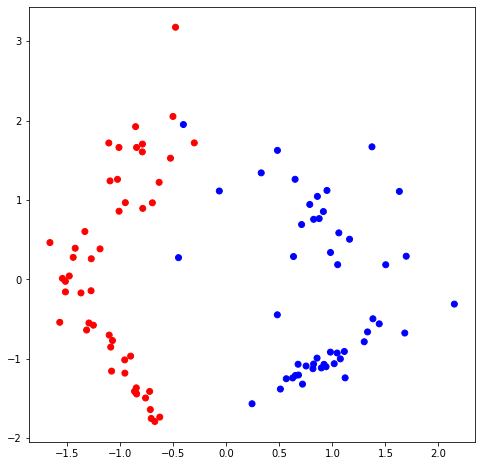

In [32]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

## Реализация логистической регрессии

In [33]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
def log_loss(w, X, y):
    m = X.shape[0]
    y=y[:, np.newaxis]
    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(X, w.T))
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    grad = 1.0 / m * np.dot((A - y).T, X)
    
    return loss, grad

In [6]:
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad
        losses.append(loss)
        
    return w, losses

In [7]:
def predict(w, X):
    y_predicted = np.zeros(X.shape[0])    
    A = sigmoid(np.dot(X, w.T))
#     За порог отнесения к тому или иному классу примем вероятность 0.5
    y_predicted[A[:, 0]>0.5]=1
    y_predicted[A[:, 0]<=0.5]=0
        
    return y_predicted

In [8]:
w0 = np.zeros((1, X_train.shape[1]))

n_iterations = 1000
eta = 0.05

w, losses = optimize(w0, X_train, y_train, n_iterations, eta)

y_predicted_test = predict(w, X_test)
y_predicted_train = predict(w, X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[3.72659902 0.22383415]]
Точность на обучающей выборке: 98.571
Точность на тестовой выборке: 96.667


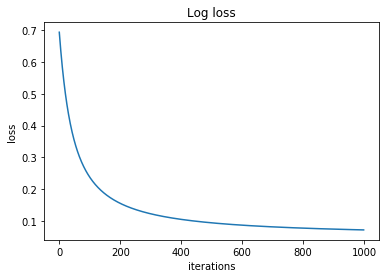

In [9]:
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses)

#### В виде класса

In [10]:
class logistic:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    @classmethod
    def log_loss(cls, w, X, y):
        m = X.shape[0]
        y=y[:, np.newaxis]
        # используем функцию сигмоиды, написанную ранее
        A = cls.sigmoid(np.dot(X, w.T))
        loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
        grad = 1.0 / m * np.dot((A - y).T, X)
        return loss, grad
    @classmethod
    def optimize(cls, w, X, y, n_iterations, eta):
        #     потери будем записывать в список для отображения в виде графика
        losses = []
        for i in range(n_iterations):        
            loss, grad = cls.log_loss(w, X, y)
            w = w - eta * grad
            losses.append(loss)
        return w, losses
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=0.05
    def fit(self, X, y):
        w0 = np.zeros((1, X.shape[1]))
        self.w, self.losses = optimize(w0, X, y, self.n_iterations, self.eta)
    def predict_proba(self, X):
        y_predicted = np.zeros(X.shape[0])    
        return self.sigmoid(np.dot(X, self.w.T)).flatten()
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

In [11]:
mod=logistic()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[3.72659902 0.22383415]]
Точность на обучающей выборке: 98.571
Точность на тестовой выборке: 96.667


## Матрица ошибок

In [12]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [46]:
print("Для порога по вероятности 0.5 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test), y_test)}")
print("Для порога по вероятности 0.75 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, 0.75), y_test)}")

Для порога по вероятности 0.5 на тестовой выборке имеем: {'TP': 15, 'FP': 0, 'FN': 1, 'TN': 14}
Для порога по вероятности 0.75 на тестовой выборке имеем: {'TP': 14, 'FP': 0, 'FN': 2, 'TN': 14}


## Методы оценки дискриминационной способности модели

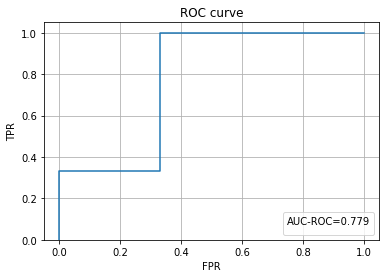

In [14]:
from numpy import trapz  # используем эту функцию для расчета площади под кривой

TPR = [0, 0.33, 0.33, 0.66, 1, 1, 1]
FPR = [0, 0, 0.33, 0.33, 0.33, 0.66, 1]

AUC_ROC = trapz(TPR, x = FPR, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

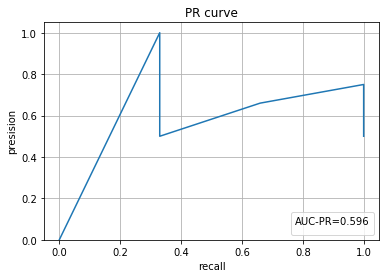

In [15]:
precision = [0, 1, 0.5, 0.66, 0.75, 0.6, 0.5]
recall = [0, 0.33, 0.33, 0.66, 1, 1, 1]

AUC_PR = trapz(precision, x = recall, dx=0.1)

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall, precision)

<b>Домашнее задание:</b><br>
Определите AUC_ROC и AUC_ROC для построенной модели на тестовой выборке.<br>
Используйте реализацию модели в виде класса и функцию confusion,<br>
чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.

<center>$\large precision = \LARGE \frac{TP}{TP \: + \: FP} \:\:\:\:\: \large recall = \LARGE \frac{TP}{TP \: + \: FN}$<center>

<center>$\large TPR = \LARGE \frac{TP}{TP \: + \: FN} \:\:\:\:\: \large FPR = \LARGE \frac{FP}{FP \: + \: TN}$<center>

In [51]:
def get_dict_precision_recall_TPR_FPR(conf_m):
    """
    Функция принимает на вход матрицу ошибок.
    Функция возвращает значения метрик в виде словаря.
    """
    TPR = conf_m['TP']/(conf_m['TP'] + conf_m['FN'])
    FPR = conf_m['FP']/(conf_m['FP'] + conf_m['TN'])
    precision = conf_m['TP']/(conf_m['TP']+conf_m['FP'])
    recall = conf_m['TP']/(conf_m['TP']+conf_m['FN'])
    return {'precision': precision, 'recall': recall, 'TPR': TPR, 'FPR': FPR}

In [65]:
TPR_list = []
FPR_list = []
precision_list = []
recall_list = []
for _thr in np.arange(0, 1.0, 0.05):
    res = get_dict_precision_recall_TPR_FPR(confusion(mod.predict(X_test, thr=_thr), y_test))
    print(f"Для порога по вероятности {_thr} на тестовой выборке имеем:\n"
      f" {res}\n")
    precision_list.append(res['precision'])
    recall_list.append(res['recall'])
    TPR_list.append(res['TPR'])
    FPR_list.append(res['FPR'])

Для порога по вероятности 0.0 на тестовой выборке имеем:
 {'precision': 0.5333333333333333, 'recall': 1.0, 'TPR': 1.0, 'FPR': 1.0}

Для порога по вероятности 0.05 на тестовой выборке имеем:
 {'precision': 0.7272727272727273, 'recall': 1.0, 'TPR': 1.0, 'FPR': 0.42857142857142855}

Для порога по вероятности 0.1 на тестовой выборке имеем:
 {'precision': 0.8421052631578947, 'recall': 1.0, 'TPR': 1.0, 'FPR': 0.21428571428571427}

Для порога по вероятности 0.15000000000000002 на тестовой выборке имеем:
 {'precision': 0.8421052631578947, 'recall': 1.0, 'TPR': 1.0, 'FPR': 0.21428571428571427}

Для порога по вероятности 0.2 на тестовой выборке имеем:
 {'precision': 0.8888888888888888, 'recall': 1.0, 'TPR': 1.0, 'FPR': 0.14285714285714285}

Для порога по вероятности 0.25 на тестовой выборке имеем:
 {'precision': 0.8888888888888888, 'recall': 1.0, 'TPR': 1.0, 'FPR': 0.14285714285714285}

Для порога по вероятности 0.30000000000000004 на тестовой выборке имеем:
 {'precision': 0.9375, 'recall': 0.93

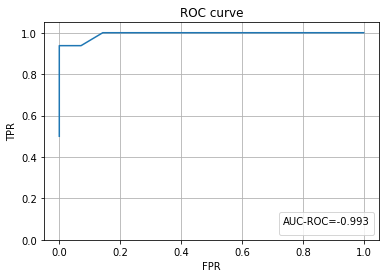

In [69]:
AUC_ROC = trapz(TPR_list, x = FPR_list, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR_list, TPR_list)

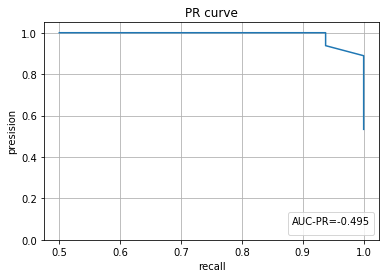

In [70]:
AUC_PR = trapz(precision_list, x = recall_list, dx=0.1)

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall_list, precision_list)